# Using Pandas read_json function:

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [2]:
# with open('yelp_dataset/yelp_academic_dataset_tip.json') as file:
#         tip = pd.read_json(file, lines = True)

In [3]:
with open('yelp_dataset/yelp_academic_dataset_review.json') as file:
        review = pd.read_json(file, lines = True)

In [4]:
with open('yelp_dataset/yelp_academic_dataset_business.json') as file:
        business = pd.read_json(file, lines = True)

In [5]:
# with open('yelp_dataset/yelp_academic_dataset_checkin.json') as file:
#         checkin = pd.read_json(file, lines = True)

In [6]:
with open('yelp_dataset/yelp_academic_dataset_user.json') as file:
        user = pd.read_json(file, lines = True)

In [7]:
# dfs = ['tip', 'review', 'business', 'checkin', 'user']

tip:  ['business_id' 'date' 'likes' 'text' 'type' 'user_id']
review:  ['business_id' 'date' 'review_id' 'stars' 'text' 'type' 'user_id' 'votes']
business:  ['attributes' 'business_id' 'categories' 'city' 'full_address' 'hours'
 'latitude' 'longitude' 'name' 'neighborhoods' 'open' 'review_count'
 'stars' 'state' 'type']
checkin:  ['business_id' 'checkin_info' 'type']
user:  ['average_stars' 'compliments' 'elite' 'fans' 'friends' 'name'
 'review_count' 'type' 'user_id' 'votes' 'yelping_since']

# Building a recommender system
First, get the relevant data: user-business stars... create matrices Y, R

** Y ** that contains #business as rows, #user as columns, values = stars

** R ** same size as Y, values = 1 if a user has rated a business **



# Need to determine businesses and users to include in the model

## Drop businesses and users with review counts less than 20

In [8]:
user = user[user.review_count > 20]

In [9]:
user.shape

(148994, 11)

In [10]:
business.shape

(85901, 15)

In [11]:
business = business[business.review_count > 20]

In [12]:
business.shape

(25680, 15)

In [13]:
business.groupby('state').size()

state
AZ     10754
BW       133
CA         3
EDH      525
FIF        1
IL       253
MLN       15
NC      1897
NV      8645
ON        85
PA      1315
QC      1125
RP         1
SC        68
TX         1
WI       858
XGL        1
dtype: int64

## Drop states with less than 20 businesses (recommend within state if #>20)

In [14]:
business = business.groupby('state').filter(lambda r: len(r) > 20)

In [15]:
business.groupby('state').size()

state
AZ     10754
BW       133
EDH      525
IL       253
NC      1897
NV      8645
ON        85
PA      1315
QC      1125
SC        68
WI       858
dtype: int64

In [16]:
business.shape

(25658, 15)

## Merge review+business+user

In [17]:
rev_biz_usr = pd.merge(pd.merge(review, business, on='business_id'), user, on='user_id')

In [18]:
rev_biz_usr.shape

(1251142, 32)

### Remove not needed columns from the dataframe, to reduce memory use:

In [19]:
col_drop = rev_biz_usr.columns.difference(['business_id', 'user_id', 'stars_x'])

In [20]:
rev_biz_usr.drop(col_drop, axis=1, inplace=True)

In [21]:
rev_biz_usr.shape

(1251142, 3)

### drop users and businesses with less than 20 reviews in the review dataframe  
**RUN multiple times until steady state**

In [22]:
#rev_biz_usr.groupby('user_id').size().reset_index(name='count').sort_values(by='count', ascending=True)

In [24]:
for _ in range(8):
    rev_biz_usr = rev_biz_usr.groupby('business_id').filter(lambda r: len(r) >= 20)
    
    rev_biz_usr = rev_biz_usr.groupby('user_id').filter(lambda r: len(r) >= 20)
    

rev_biz_usr.shape # (487156, 32)

(487156, 3)

### Convert dtype of stars to int32 instead of int64 (since their values are from 1-5), also to reduce memory use:

In [25]:
rev_biz_usr.stars_x = rev_biz_usr.stars_x.astype(int)

## Pivoting the table needed for the recommender system algorithm

#### Before filtering users and businesses, the following pivot table gave an error due to out of memory, not negagtive dimensions. However, after reducing dataset, the pivoted table fits in my laptop's 32GB memory (total code occupying nearly 8GB):
memory needed before reducing the dataset, assuming 8 bytes per value is:
686556 x 85539 x 8 / 1024 / 1024/ 1024 = 438 GB

In [26]:
# memory requirements for pivoting the table after reducing the dataset is still large ~ 27.5 GB
# Now the table can fit in memory ~ 1.33 GB
len(rev_biz_usr.business_id.unique()) * len(rev_biz_usr.user_id.unique()) * 8 / 1024/1024/1024

0.6321526765823364

In [27]:
rev_biz_usr.memory_usage()

Index          3897248
business_id    3897248
stars_x        1948624
user_id        3897248
dtype: int64

### Note that some users rated the same business multiple times, pivot table will save the average value, which is acceptable

In [28]:
#ev_biz_usr[(rev_biz_usr.business_id == '-584fn2GxYe9sLsgN2WeQA') & (rev_biz_usr.user_id == 'qqtmFGhyyHc37coT4qJxaw')]

In [29]:
#review[(review.business_id == '-584fn2GxYe9sLsgN2WeQA') & (review.user_id == 'qqtmFGhyyHc37coT4qJxaw')]

## The Y Matrix for the recommender system

### Do not fill NaNs with zeros as zeros occupy more memory than NaNs, and the pivoting command will run out of memory.

In [30]:
Y = pd.pivot_table(rev_biz_usr, index='business_id', columns='user_id', values='stars_x')#, fill_value=0)

In [31]:
Y.loc['-584fn2GxYe9sLsgN2WeQA', 'qqtmFGhyyHc37coT4qJxaw']

4.666666666666667

In [32]:
Y.shape # before dropna: (8208, 10337)

(8208, 10337)

In [33]:
Y = Y.dropna(thresh=20, axis=1)

In [34]:
Y.shape

(8208, 9773)

In [35]:
Y = Y.dropna(thresh=20, axis=0)

In [36]:
Y.shape

(7630, 9773)

In [38]:
# REPEAT A FEW TIME UNTIL WE GET A STABLE SHAPE of (7360, 9234)
for _ in range(10):
    Y = Y.dropna(thresh=20, axis=1)
    Y = Y.dropna(thresh=20, axis=0)
Y.shape

(7360, 9234)

In [55]:
#Y.drop(Y.columns[Y.count(axis=0) < 20], axis=1)

In [56]:
#Y.columns[Y.count(axis=0) < 20]

In [39]:
(Y.count(axis=1) < 20).sum()

0

In [40]:
Y.count(axis=0).min()

20

In [60]:
7360*9234

67962240

In [61]:
Y.count().sum()

423296

In [62]:
7360*9234 - Y.count().sum()

67538944

In [63]:
Y.isnull().sum().sum()

67538944

In [64]:
Y.memory_usage().sum()/1024/1024/1024

0.5064129829406738

In [77]:
# len(rev_biz_usr.business_id.unique()) , len(rev_biz_usr.user_id.unique())

# Split the data as training and test sets:

Select a random number of columns (30% of total)users, and remove some of the given ratings (-> nan)


In [41]:
test_split_ratio = 0.3
test_size = int(Y.shape[1] * test_split_ratio)
train_size = Y.shape[1] - test_size
# rand_test_user_mask = random.sample(range(Y.shape[1]), test_size)
rand_column_mask = np.random.choice(Y.shape[1], test_size, replace=False)

In [42]:
# Since number of reviews by each user is > 20, select 5 ratings as test per test user
Y_test = Y.iloc[:,rand_column_mask].copy()

In [43]:
# Tried to define a function to mask random values in each column and apply it to the DF.
# However, the function is applied (by design) twice to the first column, resulting in an error
# Better use a simple for loop

for col in Y_test:
    mask_size = 5
    mask = np.random.choice(Y_test[col].notnull().nonzero()[0], mask_size, replace=False)
    Y_test[col][mask] = np.nan

In [44]:
Y_test.count().sum()

112208

## Locations of test values

In [45]:
value_locations_premask = Y.iloc[:,rand_column_mask][Y.iloc[:,rand_column_mask].notnull()].stack().index.tolist()

In [46]:
value_locations_masked = Y_test[Y_test.notnull()].stack().index.tolist()

In [47]:
test_values_locations = list(set(value_locations_premask) - set(value_locations_masked))

In [48]:
# Convert to dataframe in order to be able to use during lookup operation, which requires list of rows, and list of columns
test_values_locations = pd.DataFrame.from_records(test_values_locations, columns=['business_id', 'user_id'])

In [49]:
# Get location positions:
query_rows = test_values_locations.business_id
rows = Y.index.values
sidx = np.argsort(rows)
row_ids = sidx[np.searchsorted(rows,query_rows,sorter=sidx)]

In [50]:
# Get location positions:
query_cols = test_values_locations.user_id
cols = Y.columns.values
sidx = np.argsort(cols)
col_ids = sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [51]:
col_ids[0:5]

array([1121, 5801, 6657, 7663, 8461], dtype=int64)

In [52]:
Y.columns.get_loc(test_values_locations.user_id[4])

8461

In [53]:
Y.index.get_loc(test_values_locations.business_id[5])

4439

In [54]:
col_ids

array([1121, 5801, 6657, ..., 7267, 4763, 7423], dtype=int64)

## Get test values 

In [55]:
Y.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ 3.,  1.,  4., ...,  4.,  4.,  3.])

In [56]:
Y.values[row_ids, col_ids]

array([ 3.,  1.,  4., ...,  4.,  4.,  3.])

## Verify masking procedeure

To test the masking steps:  
Test sample size = 0.3 * Original Size = 0.3 * 9234 = 2770  
Randomly pick 5 notnan values from these columns and set them to nan  
Number of nans should increase by 2770 * 5 = 13850

In [57]:
int(Y.shape[1]*0.3) * 5

13850

In [58]:
Y.iloc[:,rand_column_mask].count().sum()

126058

In [59]:
Y_test.count().sum()

112208

In [60]:
Y.iloc[:,rand_column_mask].count().sum() - Y_test.count().sum()

13850

# Now insert the new Nans into the original Y matrix

In [61]:
Y_test_original = Y.iloc[:,rand_column_mask].copy()

In [62]:
Y.iloc[:,rand_column_mask] = Y_test.copy()

In [63]:
Y.count().sum()

409446

## The R Matrix for the recommender system

In [64]:
# The R matrix shold be based on the new Y matrix

In [65]:
R = Y.notnull()

In [66]:
R.sum().sum()

409446

In [67]:
R.shape

(7360, 9234)

In [68]:
R.memory_usage().sum()/1024/1024 # 170 MB

64.8699951171875

### To find the mean of Y rows using the 1s in R
**For accessing reviewed items only using R**

In [69]:
R.iloc[1,:].mean()

0.0028156811782542777

In [70]:
Y.iloc[1,list(R.iloc[1,:])].mean()

4.038461538461538

In [71]:
Y.iloc[:6,:].mean(axis=1)

business_id
--5jkZ3-nUPZxUvtcbr8Uw    4.470588
--BlvDO_RG2yElKu9XA1_g    4.038462
--UE_y6auTgq3FXlvUMkbw    3.344444
--pOlFxITWnhzc7SHSIP0A    4.086538
-0Ackw6MF82PXO9f9Jh_Kg    3.435185
-0Oh0BEtQEC9OmmzZ_H5Bg    4.486486
dtype: float64

# Define the Cost Function
Initializing the parameters ($\theta$, X)

$\theta$: Model parameter 

X: model features

$Y = X * \theta^T$

for non zero values of R

$\theta$ shape = #users * #features

X shape = #business * #features

Y shape = #business * #users

Choose number of features = 100

In [72]:
def cost(params, Y, R, num_business, num_user, num_features, lamda):
    # lamda is the regularization coefficient lambda (python keyword)
    # Convert the dataframe to ndarray, fill nans with zeros, and leave the answer array for easier linear algebra operations
#     Y_mat = np.nan_to_num(Y.as_matrix())
#     R_mat = np.nan_to_num(R.as_matrix())

    # unfold X and theta from the 1D params array
    X = np.reshape(params[:num_business*num_features], (num_business, num_features))
    theta = np.reshape(params[num_business*num_features:], (num_user, num_features))    
    
    J = 0.5*np.sum(pow((X@theta.T - Y)*R,2)) + lamda/2*(np.sum(pow(theta,2)) + np.sum(pow(X,2)))
    
    X_grad = (X@theta.T - Y)*R@theta + lamda*X
    theta_grad = (X@theta.T - Y).T * R.T@X + lamda*theta
    
    grad = np.concatenate((np.ravel(X_grad), np.ravel(theta_grad)))
    print('The cost is currently equal to.........', J)
    return J, grad
    

In [157]:
J, grad = cost(params, np.nan_to_num(Y.as_matrix()), np.nan_to_num(R.as_matrix()), num_business, num_user, num_features, 0)
J

The cost is currently equal to......... 7320488.93105


7320488.9310533069

In [104]:
# checking some numpy matrix operations
a = np.array([[1.,2],[3,4]])
print('a=', a)

b = np.array([[5,6],[7,8]])
print('b=', b)

print('*', a*b)

print('@',a@b)

c = np.asmatrix(a)
print('c=', c)

print('*', c*b)

np.sum(c)

a= [[ 1.  2.]
 [ 3.  4.]]
b= [[5 6]
 [7 8]]
* [[  5.  12.]
 [ 21.  32.]]
@ [[ 19.  22.]
 [ 43.  50.]]
c= [[ 1.  2.]
 [ 3.  4.]]
* [[ 19.  22.]
 [ 43.  50.]]


10.0

# Set the number of features, number of businesses and users:

In [74]:
num_features = 75
num_business = Y.shape[0]
num_user = Y.shape[1]

# Initialize and train the model:



In [85]:
lamda = 10

X = np.random.randn(num_business, num_features)
theta = np.random.randn(num_user, num_features)
params = np.concatenate((np.ravel(X), np.ravel(theta)))

Y_mat = Y.as_matrix()

Ymean = np.nanmean(Y_mat, axis=1, keepdims=True)

Y_mat = np.nan_to_num(Y_mat)
R_mat = np.nan_to_num(R.as_matrix())

# Ymean = np.zeros((num_business, 1))  
# Ynorm = np.zeros((num_business, num_user))

Ynorm = np.nan_to_num(Y.subtract(Y.mean(axis=1), axis=0).as_matrix())

# for i in range(num_business):  
#     idx = np.where(R_mat[i,:] == 1)[0]
#     Ymean[i] = Y.iloc[i,idx].mean()
#     Ynorm[i,idx] = Y.iloc[i,idx] - Ymean[i]

# Ynorm = Y - Y.mean()

In [86]:
Ymean[:5]

array([[ 4.47058824],
       [ 4.03846154],
       [ 3.34444444],
       [ 4.08653846],
       [ 3.43518519]])

In [87]:
(Y_mat[0,:] - Ymean[0]) == Ynorm[0,:]

array([False, False, False, ..., False, False, False], dtype=bool)

In [88]:
Y_mat[0,:] - Ymean[0]

array([-4.47058824, -4.47058824, -4.47058824, ..., -4.47058824,
       -4.47058824, -4.47058824])

In [89]:
np.where(R_mat == 1)

(array([   0,    0,    0, ..., 7359, 7359, 7359], dtype=int64),
 array([ 162,  519, 1229, ..., 8798, 8915, 8940], dtype=int64))

In [90]:
Ynorm[0,162]

-0.47058823529411775

In [91]:
Ynorm[0,162]

-0.47058823529411775

In [92]:
Y_mat[0,162]

4.0

In [93]:
4 - Ymean[0]

array([-0.47058824])

In [94]:
(Y_mat- Ymean)[0, 162]

-0.47058823529411775

In [95]:
fmin = minimize(fun=cost, x0=params, args=(Ynorm, R_mat, num_business, num_user, num_features, lamda),  
                method='CG', jac=True, options={'maxiter': 100})
X = np.matrix(np.reshape(fmin.x[:num_business * num_features], (num_business, num_features)))  
theta = np.matrix(np.reshape(fmin.x[num_business * num_features:], (num_user, num_features)))

The cost is currently equal to......... 21851068.3291
The cost is currently equal to......... 21851068.3291
The cost is currently equal to......... 21738901.4188
The cost is currently equal to......... 21296395.8143
The cost is currently equal to......... 19622379.2022
The cost is currently equal to......... 14305127.0414
The cost is currently equal to......... 7149782.21344
The cost is currently equal to......... 138635229.596
The cost is currently equal to......... 4722974.30185
The cost is currently equal to......... 5215142.09898
The cost is currently equal to......... 3837941.21672
The cost is currently equal to......... 3013190.14669
The cost is currently equal to......... 2279124.77852
The cost is currently equal to......... 3137301.56804
The cost is currently equal to......... 1961918.84229
The cost is currently equal to......... 1597474.95423
The cost is currently equal to......... 1209687.63568
The cost is currently equal to......... 741059.906227
The cost is currently equal 

In [99]:
## lamda = 10:
# For 100 features after 20 iterations cost = 271'813 @ 2m 8s
# For 50 features after 20 iterations cost = 186'694 @ 1m 0s
# For 50 features after 100 iterations cost = 168'915 @ 8m 37s
## lamda = 1:
# For 50 features after 20 iterations cost = 142325 @ 2m 0s (might be overfitting)
## lambda = 10
# For 75 features after 100 iterations cost = 168131 @ 7m 55s 


## Get Predictions

In [96]:
predictions = X * theta.T + Ymean

In [97]:
predictions[0,162]

4.4091564124593345

## Evaluate Recommender System

In [100]:
Y.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [101]:
Y.values[row_ids, col_ids]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [102]:
Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)

array([ 3.,  1.,  4., ...,  4.,  4.,  3.])

In [103]:
predictions[row_ids, col_ids]

matrix([[ 4.28126004,  2.72389802,  3.30053242, ...,  3.67240865,
          3.80029883,  3.37023989]])

### Clip the predictions between 1 and 5

In [104]:
a

NameError: name 'a' is not defined

In [458]:
a.clip(min=1, max=2.5)

array([[ 1. ,  2. ],
       [ 2.5,  2.5]])

In [460]:
a.clip(1,2.5)

array([[ 1. ,  2. ],
       [ 2.5,  2.5]])

In [459]:
a

array([[ 1.,  2.],
       [ 3.,  4.]])

In [121]:
predictions.max()

7.0222717635296918

In [105]:
predictions.clip(1, 5)

matrix([[ 4.49422919,  4.54370438,  4.4382212 , ...,  4.49377218,
          4.49853221,  4.47802365],
        [ 4.07643662,  3.93724457,  4.10343748, ...,  4.0221997 ,
          4.05263656,  4.06454907],
        [ 3.41245866,  3.42405444,  3.46440539, ...,  3.32585637,
          3.33346986,  3.25407767],
        ..., 
        [ 3.90487243,  3.98154187,  4.05117032, ...,  3.84266437,
          4.00600982,  3.84433406],
        [ 3.84035521,  3.52611689,  3.58816259, ...,  3.61890522,
          3.64721953,  3.55447738],
        [ 4.23040225,  4.09732248,  4.16746507, ...,  4.12897502,
          4.15317959,  4.12153109]])

## Find the mean squared error (MSE) for the test set

### With clipping the values to [1, 5] and rounding the results to nearest integer

In [106]:
np.mean(np.power((np.round(predictions[row_ids, col_ids].clip(1,5)) - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.1534898565416272

In [107]:
# for 50 features lambda 1, 20 iterations, the MSE is 2.59
# for 75 features lambda 10, 100 iterations, the MSE is 1.15

### With clipping but without rounding the results

In [108]:
np.mean(np.power((predictions[row_ids, col_ids].clip(1,5) - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.0722902251466881

In [109]:
# for 50 features lambda 1, 20 iterations, the MSE is 2.51
# for 75 features lambda 10, 100 iterations, the MSE is 1.07

### Without clipping nor rounding:

In [110]:
np.mean(np.power((predictions[row_ids, col_ids] - Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)),2))

1.0723211264887937

In [109]:
# for 50 features lambda 1, 20 iterations, the MSE is 3.83
# for 75 features lambda 10, 100 iterations, the MSE is 1.07

### Acuracy: not a good measure for recommendation systems

In [111]:
(np.round(predictions[row_ids, col_ids]) == Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id)).sum()/row_ids.shape

array([ 0.36382671])

In [112]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.02275
# for 75 features lambda 10, 100 iterations, the accuracy is 0.36383

## Another Evaluation metric: 
If predictions >= 3 and Original test value also >= 3, then the recommendation is correct, the same for values < 3 

otherwise, the recommendation is incorrect 

Can use precision/recall/F1 score


In [113]:
# Accuracy:
((np.round(predictions[row_ids, col_ids]) >= 3) & (Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id) >= 3) | 
 (predictions[row_ids, col_ids] < 3) & (Y_test_original.lookup(test_values_locations.business_id, test_values_locations.user_id) < 3)).mean()

0.87740072202166064

In [114]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.75466
# for 75 features lambda 10, 100 iterations, the accuracy is 0.87740

In [480]:
(3 >= 3) & (4 > 3) | (2 < 3 and 4 < 3)

True

In [440]:
row_ids.max(), col_ids.max()

(7359, 9227)

In [115]:
predictions.shape

(7360, 9234)

In [116]:
# compare the Y_test to predicted values
Y_test.columns

Index(['LL4cvz4wDhw9i0BIXEGd5w', 'svP9WkoIMN3Wta7W9ZhawA',
       'FKKKysCfKpCVU2H2U2GzEg', 'Capf_zG28-3Kx68BegCyAA',
       'dahsxCK5VCYRHccVS1udmQ', 'TBep3v7jQCYbzgJpG1fkyg',
       'l2zoX2M4OBuAE_q2A5qW8A', 'vNB330u1pHhCEd-UZrE2RA',
       'bddW9P6WE4y1PQyaya5VxA', '2Az24juAhTJtmlqr5UWXSQ',
       ...
       '2ThogyfqUnLoRiG-n03b0g', 'tFLi8-M6MOOrY5CsvWHRMA',
       'DMCGCo1D88u61SBx8jXAWg', 'AnH84g9V10x41CXmCvcaFg',
       'w5AF-YHSxHBaZdvz0nGjzA', 'eZYqkKpOyDZfIvAVNJvmdg',
       'w_hcSjqLeSZQL9Rx1UP-Tw', '6yTkDWCDGGH_5-Pr165WUg',
       'jVLMfm2v2U49y6Sjlm_EeA', 'lVB2vVsITEPtg4yjqk3oxg'],
      dtype='object', name='user_id', length=2770)

In [117]:
predictions[predictions[:,1].argsort(axis=0)[::-1],1]

matrix([[ 5.10811513],
        [ 4.96574401],
        [ 4.9498566 ],
        ..., 
        [ 1.58638254],
        [ 1.5165084 ],
        [ 1.47612271]])

In [118]:
predictions[:,1].max()

5.108115131041199

In [122]:
Y.iloc[:,1].max()

5.0

In [123]:
predictions.shape

(7360, 9234)

## Evaluate the whole Y matrix (not null values)

In [124]:
all_value_idx = Y[Y.notnull()].stack().index.tolist()

In [125]:
all_value_idx = pd.DataFrame.from_records(all_value_idx, columns=['business_id', 'user_id'])

In [126]:
Y.lookup(all_value_idx.business_id, all_value_idx.user_id).shape

(409446,)

In [127]:
query_r = all_value_idx.business_id
r = Y.index.values
aridx = np.argsort(r)
all_row_ids = aridx[np.searchsorted(r,query_r,sorter=aridx)]

In [128]:
query_c = all_value_idx.user_id
c = Y.columns.values
acidx = np.argsort(c)
all_col_ids = acidx[np.searchsorted(c,query_c,sorter=acidx)]

In [129]:
((np.round(predictions[all_row_ids, all_col_ids]) >= 3) & (Y.lookup(all_value_idx.business_id, all_value_idx.user_id) >= 3) | 
 (predictions[all_row_ids, all_col_ids] < 3) & (Y.lookup(all_value_idx.business_id, all_value_idx.user_id) < 3)).mean()

0.94415136550363177

In [130]:
# for 50 features lambda 1, 20 iterations, the accuracy is 0.9878
# for 75 features lambda 10, 100 iterations, the accuracy is 0.9442

# Conclusion of Performance:
* **The overall accuracy of the dataset, including the masked values is about 98.8% (maybe overfitting) or 94.4%**

* **The recommender system model captures the ratings with a good accuracy based on hit or miss evaluation**

* **The performance on the test set was better with 75 features, lambda=10, 100 iterations with an MSE = 1.07**

# (REACHED HERE) Recommed businesses to users

In [295]:
def recommend(Y, predictions, user_id):
    # get index position of user_id
    user_idx = Y.columns.get_loc(user_id)    
    # find index positions of non reviewed businesses for this user:
    all_recommendations = np.squeeze(np.asarray(np.argsort(predictions[:,user_idx], axis=0)))
    rated_businesses = [Y.loc[:,user_id].index.get_loc(i) for i in Y.loc[:,user_id][Y.loc[:,user_id].notnull()].index.tolist()]
    all_recommendations = all_recommendations[~np.in1d(all_recommendations,rated_businesses)]
    return 0, all_recommendations
    # find reviewed businesses, find predictions(recommendations) for our user, return businesses in reverse sorted order
    # remove reviewed businesses from recommendations

In [298]:
recommended_business_name, recommended_business_idx = recommend(Y, predictions, Y.columns[1])

In [317]:
recommended_business_name = Y.index[recommended_business_idx][:10]

In [318]:
recommended_business_name

Index(['CJ8IURVsHxTIu2Kzp2Kumw', 'inDYSqSDMyrfBhOZc702rw',
       'wyqwO4ZqZyRR6pGk1pTBrA', 'GQ6bCvYZxdGY6ZQyeZFeVg',
       'UuBZkKnckkRmYt3jFn2gaQ', 'cSYSUZ3YbwR_RTughnoy5A',
       '3e9IUI5Dt-ktDKEQNkENVA', 'PEyRw3HOWcDnd2XHRLq5RQ',
       'vKtMsWeAaThimXGo9Ic_Og', '_G5pDGRJL0mhLRgIViW2sA'],
      dtype='object', name='business_id')

In [319]:
business[business.business_id.isin(recommended_business_name)]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
977,{'Accepts Credit Cards': True},vKtMsWeAaThimXGo9Ic_Og,"[Professional Services, Home Services, Home Au...",Charlotte,"316 E Morehead St\nSouth End\nCharlotte, NC 28203","{'Sunday': {'close': '18:00', 'open': '12:00'}...",35.218730,-80.849720,Time Warner Cable,"[South End, Dilworth]",True,91,1.5,NC,business
9692,"{'By Appointment Only': True, 'Accepts Credit ...",GQ6bCvYZxdGY6ZQyeZFeVg,"[Professional Services, Television Service Pro...",Las Vegas,"1700 Vegas Dr\nLas Vegas, NV 89106","{'Wednesday': {'close': '21:00', 'open': '07:0...",36.189293,-115.162965,Cox Communications,[],True,253,1.5,NV,business
21084,"{'Price Range': 2, 'Parking': {'street': False...",cSYSUZ3YbwR_RTughnoy5A,"[Shopping Centers, Shopping]",Phoenix,"9617 N Metro Pkwy W\nPhoenix, AZ 85051","{'Sunday': {'close': '18:00', 'open': '11:00'}...",33.576494,-112.120861,Metrocenter Mall,[],True,125,2.0,AZ,business
22358,"{'By Appointment Only': True, 'Accepts Credit ...",inDYSqSDMyrfBhOZc702rw,"[Professional Services, Television Service Pro...",Phoenix,"Phoenix, AZ 85027","{'Sunday': {'close': '00:00', 'open': '00:00'}...",33.678238,-112.101291,Cox Communications,[],True,517,1.5,AZ,business
28414,"{'Accepts Insurance': True, 'Price Range': 1, ...",3e9IUI5Dt-ktDKEQNkENVA,"[Food, Department Stores, Grocery, Fashion, Sh...",Phoenix,"3721 E Thomas Rd\nPhoenix, AZ 85018",{},33.479007,-112.000813,Walmart Supercenter,[],True,100,1.5,AZ,business
28893,"{'Wi-Fi': 'free', 'Good For': {'breakfast': Tr...",UuBZkKnckkRmYt3jFn2gaQ,"[Casinos, Arts & Entertainment, American (New)...",Las Vegas,Circus Circus Las Vegas\n2800 Las Vegas Blvd S...,"{'Sunday': {'close': '21:00', 'open': '16:30'}...",36.137667,-115.164659,Circus Buffet,[The Strip],True,272,2.0,NV,business
29153,{},wyqwO4ZqZyRR6pGk1pTBrA,"[Hotels & Travel, Car Rental]",Las Vegas,"7135 Gilespie St\nSoutheast\nLas Vegas, NV 89119","{'Sunday': {'close': '00:00', 'open': '00:00'}...",36.060061,-115.165044,Payless Car Rental,[Southeast],True,474,1.5,NV,business
33178,"{'Smoking': 'no', 'Price Range': 3, 'Alcohol':...",_G5pDGRJL0mhLRgIViW2sA,"[Arts & Entertainment, Performing Arts]",Las Vegas,Luxor Las Vegas\n3900 Las Vegas Blvd S\nThe St...,"{'Friday': {'close': '22:00', 'open': '12:00'}...",36.095580,-115.175818,Cirque du Soleil - Criss Angel Believe,[The Strip],False,833,1.5,NV,business
36354,"{'Wi-Fi': 'paid', 'Good For Groups': True, 'Al...",CJ8IURVsHxTIu2Kzp2Kumw,"[Buffets, Restaurants]",Las Vegas,Imperial Palace Hotel & Casino\n3535 Las Vegas...,"{'Sunday': {'close': '21:00', 'open': '07:00'}...",36.118346,-115.170129,Emperor's Buffet,[The Strip],False,57,1.5,NV,business
82833,{'Good for Kids': False},PEyRw3HOWcDnd2XHRLq5RQ,"[Arts & Entertainment, Festivals]",Glendale,"5812 W Glendale Ave\nGlendale, AZ 85301",{},33.539228,-112.184329,Glendale's Best Street Food Festival,[],True,49,1.5,AZ,business


In [299]:
recommended_business_idx.shape

(7235,)

In [265]:
y = (np.squeeze(np.asarray(np.argsort(predictions[:,0], axis=0))))

In [266]:
y

array([1572, 7016, 5367, ..., 4397, 1599, 5783], dtype=int64)

In [259]:
y[~np.in1d(y,[5367])]

array([1572, 7016, 4670, ..., 4397, 1599, 5783], dtype=int64)

In [226]:
Y.columns.get_loc('--65q1FpAL_UQtVZ2PTGew')

1

In [283]:
all_recommendations = np.squeeze(np.asarray(np.argsort(predictions[:,1], axis=0)))

In [286]:
all_recommendations

array([1572, 5367, 7016, ..., 6788, 5783, 5706], dtype=int64)

In [290]:
rated_businesses = [Y.loc[:,'--65q1FpAL_UQtVZ2PTGew'].index.get_loc(i) for i in Y.loc[:,'--65q1FpAL_UQtVZ2PTGew'][Y.loc[:,'--65q1FpAL_UQtVZ2PTGew'].notnull()].index.tolist()]
len(rated_businesses)

125

In [294]:
all_recommendations[~np.in1d(all_recommendations,rated_businesses)]

array([1572, 5367, 7016, ..., 6788, 5783, 5706], dtype=int64)

In [293]:
7235+125

7360

In [237]:
predictions[1:20,1]

matrix([[ 3.93724457],
        [ 3.42405444],
        [ 4.05780711],
        [ 3.55669121],
        [ 4.46531632],
        [ 3.72074295],
        [ 3.28717477],
        [ 3.8748418 ],
        [ 4.52129513],
        [ 4.48382353],
        [ 3.71396567],
        [ 3.02185188],
        [ 3.90637287],
        [ 4.12428613],
        [ 4.57312172],
        [ 4.021725  ],
        [ 3.31265555],
        [ 4.16293033],
        [ 4.71603763]])

In [262]:
([Y.iloc[:,0].index.get_loc(i) for i in Y.iloc[:,0][Y.iloc[:,0].notnull()].index.tolist()])

[1255,
 1343,
 1736,
 1857,
 2289,
 2347,
 3102,
 3438,
 3742,
 4090,
 4362,
 4611,
 4860,
 5282,
 5573,
 5692,
 6701]

In [174]:
import matplotlib.pyplot as plt

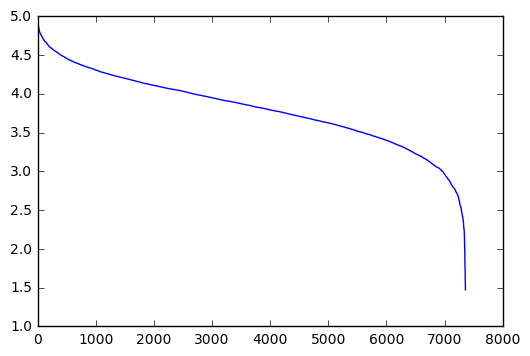

In [175]:
plt.plot(predictions[np.argsort(np.ravel(predictions[:,0]))[::-1], 0])
plt.show()

In [186]:
np.squeeze(np.argsort(predictions[:,0], axis=0))

matrix([[1572, 7016, 5367, ..., 4397, 1599, 5783]], dtype=int64)

In [156]:
np.asarray((predictions[:,0]))

array([[ 4.49422919],
       [ 4.07643662],
       [ 3.41245866],
       ..., 
       [ 3.90487243],
       [ 3.84035521],
       [ 4.23040225]])

In [177]:
np.argsort([1,2,6,5,23])[::-1]

array([4, 2, 3, 1, 0], dtype=int64)

# APPENDIX: Testing the cost function with Andrew Ng's Example

In [443]:
# Testing the cost function and implementation on a dataset with a known answer(Andrew Ng's)
def testing():
    from scipy.io import loadmat
    data = loadmat('ex8_movies.mat')
#     Y = data['Y']
#     R = data['R']
#     Y.shape, R.shape
#     users = 4  
#     movies = 5  
#     features = 3

#     params_data = loadmat('ex8_movieParams.mat')  
#     X = params_data['X']  
#     Theta = params_data['Theta']

#     X_sub = X[:movies, :features]  
#     Theta_sub = Theta[:users, :features]  
#     Y_sub = Y[:movies, :users]  
#     R_sub = R[:movies, :users]
#     params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))
    

    
    movie_idx = {}  
    f = open('movie_ids.txt')  
    for line in f:  
        tokens = line.split(' ')
        tokens[-1] = tokens[-1][:-1]
        movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

    ratings = np.zeros((1682, 1))

    ratings[0] = 4  
    ratings[6] = 3  
    ratings[11] = 5  
    ratings[53] = 4  
    ratings[63] = 5  
    ratings[65] = 3  
    ratings[68] = 5  
    ratings[97] = 2  
    ratings[182] = 4  
    ratings[225] = 5  
    ratings[354] = 5
    
    R = data['R']
    Y = data['Y']
    Y = np.append(Y, ratings, axis=1)  
    R = np.append(R, ratings != 0, axis=1)  
    from scipy.optimize import minimize

    movies = Y.shape[0]  
    users = Y.shape[1]  
    features = 10  
    learning_rate = 10.

    X = np.random.random(size=(movies, features))  
    Theta = np.random.random(size=(users, features))  
    params = np.concatenate((np.ravel(X), np.ravel(Theta)))

    Ymean = np.zeros((movies, 1))  
    Ynorm = np.zeros((movies, users))

    for i in range(movies):  
        idx = np.where(R[i,:] == 1)[0]
        Ymean[i] = Y[i,idx].mean()
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]

    fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, movies, users, features, learning_rate),  
                    method='CG', jac=True, options={'maxiter': 100, 'disp':True})
    print(fmin)
    X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))  
    Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))
    
    predictions = X * Theta.T
    my_preds = predictions[:, -1] + Ymean
    idx = np.argsort(my_preds, axis=0)[::-1]  
    print("Top 10 movie predictions:")  
    for i in range(10):  
        j = int(idx[i])
        print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))
    #return cost(params, pd.DataFrame(Y_sub), pd.DataFrame(R_sub), features, 1.5)

In [444]:
testing()

The cost is currently equal to......... 434829.17492
The cost is currently equal to......... 434829.17492
The cost is currently equal to......... 408754.420477
The cost is currently equal to......... 319567.708067
The cost is currently equal to......... 141671.966108
The cost is currently equal to......... 826367.504943
The cost is currently equal to......... 104206.23712
The cost is currently equal to......... 86914.1501693
The cost is currently equal to......... 67517.3621203
The cost is currently equal to......... 70794.9155707
The cost is currently equal to......... 60246.3512986
The cost is currently equal to......... 52793.4544583
The cost is currently equal to......... 50083.9248201
The cost is currently equal to......... 48203.6543201
The cost is currently equal to......... 45924.5158052
The cost is currently equal to......... 45100.3193639
The cost is currently equal to......... 44979.2361376
The cost is currently equal to......... 43544.4022095
The cost is currently equal to.

# Old stuff below

## Check some values after conversion

In [143]:
Y_mat[1,2]

nan

In [160]:
Y.first_valid_index()

'--5jkZ3-nUPZxUvtcbr8Uw'

In [170]:
Y.loc['--5jkZ3-nUPZxUvtcbr8Uw'].first_valid_index()

'0BT613A1PBxuwxUzjEb6VQ'

In [169]:
Y.loc['--5jkZ3-nUPZxUvtcbr8Uw','0BT613A1PBxuwxUzjEb6VQ']

4.0

In [167]:
Y.index.get_loc('--5jkZ3-nUPZxUvtcbr8Uw')

0

In [168]:
Y.loc['--5jkZ3-nUPZxUvtcbr8Uw'].index.get_loc('0BT613A1PBxuwxUzjEb6VQ')

162

In [187]:
Y_mat[0,227]

4.0

In [171]:
Y_mat[0,0]

NameError: name 'Y_mat' is not defined

In [171]:
Y_mat = np.nan_to_num(Y_mat)

In [178]:
np.isnan(Y_mat).sum()

0

# Using a sparse matrix:
http://stackoverflow.com/questions/31661604/efficiently-create-sparse-pivot-tables-in-pandas

In [96]:
from scipy.sparse import csr_matrix

users = list(sorted(rev_biz_usr.user_id.unique()))
businesses = list(sorted(rev_biz_usr.business_id.unique()))

stars = rev_biz_usr['stars_x'].tolist()
row = rev_biz_usr.user_id.astype('category', categories=users).cat.codes
col = rev_biz_usr.business_id.astype('category', categories=businesses).cat.codes
sparse_matrix = csr_matrix((stars, (row, col)), shape=(len(users), len(businesses)))

In [37]:
sparse_matrix

NameError: name 'sparse_matrix' is not defined

In [196]:
sparse_matrix

<144265x25629 sparse matrix of type '<class 'numpy.int32'>'
	with 1201156 stored elements in Compressed Sparse Row format>

In [197]:
len(sparse_matrix.indptr)

144266

## The R matrix can be easily obtained by first converting the csr to coo and using the ij values

```
sr_matrix.tocoo(copy=True)

    Convert this matrix to COOrdinate format.

    With copy=False, the data/indices may be shared between this matrix and the resultant coo_matrix.
```

In [199]:
coo_mat = sparse_matrix.tocoo()

In [200]:
len(coo_mat.row)

1201156

In [201]:
R = list(zip(coo_mat.row,coo_mat.col))

In [203]:
sorted(R)

[(0, 15977),
 (1, 6023),
 (1, 10013),
 (1, 12667),
 (1, 17546),
 (1, 19296),
 (1, 22532),
 (2, 24831),
 (3, 447),
 (3, 3221),
 (3, 8781),
 (3, 11898),
 (4, 652),
 (4, 4332),
 (4, 4645),
 (4, 4721),
 (4, 4984),
 (4, 5948),
 (4, 6324),
 (4, 7945),
 (4, 8192),
 (4, 9895),
 (4, 10773),
 (4, 10826),
 (4, 11546),
 (4, 12097),
 (4, 13059),
 (4, 13246),
 (4, 13502),
 (4, 13605),
 (4, 14262),
 (4, 14961),
 (4, 15180),
 (4, 15795),
 (4, 16131),
 (4, 16960),
 (4, 18093),
 (4, 18538),
 (4, 19564),
 (4, 19983),
 (4, 21848),
 (4, 23434),
 (5, 1484),
 (5, 1592),
 (5, 2213),
 (5, 2281),
 (5, 9698),
 (5, 10180),
 (5, 12386),
 (5, 14886),
 (5, 15513),
 (5, 18589),
 (5, 18843),
 (5, 22498),
 (5, 24981),
 (6, 363),
 (6, 814),
 (6, 831),
 (6, 874),
 (6, 900),
 (6, 972),
 (6, 1243),
 (6, 1571),
 (6, 1808),
 (6, 1831),
 (6, 1917),
 (6, 1931),
 (6, 2232),
 (6, 2613),
 (6, 2631),
 (6, 2694),
 (6, 3016),
 (6, 3102),
 (6, 3165),
 (6, 4110),
 (6, 4682),
 (6, 4711),
 (6, 4754),
 (6, 5099),
 (6, 5401),
 (6, 5603),


# Check if cities and distances between them may be used instead of distances between businesses

##  No: cities are small, with distances that can be 3 miles

# assume 30 km as maximum distance willing to travel, to find vicinity within state

In [40]:
business.latitude.min(), business.latitude.max()

(32.865882499999998, 56.033777299999997)

In [59]:
business.longitude.min(), business.longitude.max()

(-115.38655, 8.5492494004572208)

In [41]:
vincenty((57, -71), (57, -72)).km

60.77164272792849

In [42]:
vincenty((32, -71), (32, -72)).km

94.49280502196765

In [58]:
vincenty((45, -71), (45, -72)).km

78.8463347093115

for out dataset, businesses lie within latitudes 32 and 56 North

where 1 degree in longitude ranges between 60 to 95 km

so nearby business ( < 30) should also be within 0.5 degree of longitude (near 32N distances will be < 47km)

for latitudes, one degree difference is about 110 km, so will adopt 0.3 difference to consider nearby businesses

In [53]:
vincenty((44, -71), (45, -71)).km

111.12200826241184

In [54]:
vincenty((44, -70), (45, -70)).km

111.12200826241184

In [55]:
vincenty((55, -71), (56, -71)).km

111.33269933263972

In [56]:
vincenty((32, -71), (33, -71)).km

110.89560891986069

In [65]:
business[business.latitude > 56.033]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
47693,{},4Yh57FsAyvDtZsq5F7fCWg,"[Hotels & Travel, Public Transportation, Trans...",Inverkeithing,Boreland Rd\nInverkeithing KY11 1NJ,{},56.033777,-3.393267,Inverkeithing Railway Station,[],True,3,3.0,FIF,business


In [101]:
business.groupby(['state']).filter(lambda r: len(r) > 20).state.unique()

array(['PA', 'NC', 'SC', 'WI', 'IL', 'AZ', 'NV', 'QC', 'ON', 'EDH', 'MLN',
       'BW'], dtype=object)

In [102]:
# ignore states with less than 20 businesses... we have 12 states with more than 20 businesses
business_state = business.groupby(['state']).filter(lambda r: len(r) >= 20)

In [103]:
business_state.groupby('state').size()

state
AZ     36500
BW      1055
EDH     3297
IL       808
MLN      161
NC      6835
NV     23591
ON       530
PA      4086
QC      5591
SC       325
WI      3066
dtype: int64

In [106]:
business_state.shape

(85845, 15)

In [111]:
business_state[business_state.review_count > 20].count()

attributes       25673
business_id      25673
categories       25673
city             25673
full_address     25673
hours            25673
latitude         25673
longitude        25673
name             25673
neighborhoods    25673
open             25673
review_count     25673
stars            25673
state            25673
type             25673
dtype: int64

In [127]:
len(business_state[business.state == 'AZ'].merge(review, how='inner', left_on='business_id', right_on='business_id').user_id.unique())

C:\Users\ali_a\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


247028

In [168]:
# To classify a business as Food:
business.attributes.iloc[3]['Good For']

{'breakfast': False,
 'brunch': False,
 'dessert': False,
 'dinner': False,
 'latenight': False,
 'lunch': True}

In [166]:
sum(business.attributes.iloc[3]['Good For'].values())

1

In [76]:
business_state.longitude.max()

8.5492494004572208

In [70]:
business_groups = business_state.groupby('state')

In [71]:
group = business_groups.get_group('EDH')

In [72]:
group.latitude.max()

56.000421000000003

In [766]:
nearby ={}
max_nearbies = 0

business_groups = business_state.groupby('state')

for name, group in business_groups:
    for i in range(0, len(group)):
        if group.latitude.iloc[i] < 80:
            near_group = group[(group.latitude < (group.latitude.iloc[i] + 1)) & (group.latitude > (group.latitude.iloc[i] - 1)) & 
                          (group.longitude < (group.longitude.iloc[i] + 1)) & (group.longitude > (group.longitude.iloc[i] - 1))]
        for j in range(0, len(near_group)):

            distance = vincenty(tuple(group.iloc[i][['latitude','longitude']]), tuple(near_group.iloc[j][['latitude','longitude']])).km
            if distance < 30:
                c += 1
                try:
                    nearby[group.business_id.iloc[i]].extend([near_group.business_id.iloc[j]])
                except KeyError as e:
                    nearby[group.business_id.iloc[i]] = [near_group.business_id.iloc[j]]
                try:
                    nearby[near_group.business_id.iloc[j]].extend([group.business_id.iloc[i]])
                except KeyError as e:
                    nearby[near_group.business_id.iloc[j]] = [group.business_id.iloc[i]]
        if max_nearbies < c:
            max_nearbies = c
    print (len(group))


KeyboardInterrupt: 

In [755]:
business_state[(abs(business_state.latitude) < (business_state.latitude[0] + 1))]

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,"{'Take-out': True, 'Has TV': False, 'Noise Lev...",5UmKMjUEUNdYWqANhGckJw,"[Fast Food, Restaurants]",Dravosburg,"4734 Lebanon Church Rd\nDravosburg, PA 15034","{'Tuesday': {'open': '11:00', 'close': '21:00'...",40.354327,-79.900706,Mr Hoagie,[],True,7,3.5,PA,business
1,"{'Outdoor Seating': False, 'Good For Groups': ...",UsFtqoBl7naz8AVUBZMjQQ,[Nightlife],Dravosburg,"202 McClure St\nDravosburg, PA 15034",{},40.350553,-79.886814,Clancy's Pub,[],True,5,3.0,PA,business
2,{'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354115,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business
3,"{'Good For Groups': True, 'Has TV': True, 'Smo...",mVHrayjG3uZ_RLHkLj-AMg,"[Bars, American (New), Nightlife, Lounges, Res...",Braddock,"414 Hawkins Ave\nBraddock, PA 15104","{'Tuesday': {'open': '10:00', 'close': '19:00'...",40.408830,-79.866211,Emil's Lounge,[],True,26,4.5,PA,business
4,"{'Parking': {'valet': False, 'validated': Fals...",mYSpR_SLPgUVymYOvTQd_Q,"[Active Life, Golf]",Braddock,"1000 Clubhouse Dr\nBraddock, PA 15104","{'Thursday': {'open': '11:00', 'close': '20:00...",40.403405,-79.855782,Grand View Golf Club,[],True,3,5.0,PA,business
5,"{'Good For Groups': True, 'Has TV': True, 'Smo...",KayYbHCt-RkbGcPdGOThNg,"[Bars, American (Traditional), Nightlife, Rest...",Carnegie,"141 Hawthorne St\nGreentree\nCarnegie, PA 15106","{'Monday': {'open': '11:00', 'close': '02:00'}...",40.415486,-80.067549,Alexion's Bar & Grill,[Greentree],True,23,4.0,PA,business
6,{'Accepts Credit Cards': True},b12U9TFESStdy7CsTtcOeg,"[Auto Repair, Automotive, Tires]",Carnegie,"718A Hope Hollow Rd\nCarnegie, PA 15106","{'Monday': {'open': '07:30', 'close': '18:00'}...",40.394588,-80.084454,Flynn's Tire & Auto Service,[],True,9,2.5,PA,business
7,{'Good for Kids': True},Sktj1eHQFuVa-M4bgnEh8g,"[Active Life, Mini Golf]",Carnegie,"920 Forsythe Rd\nCarnegie\nCarnegie, PA 15106",{},40.405404,-80.076267,Forsythe Miniature Golf & Snacks,[Carnegie],False,4,4.0,PA,business
8,{},3ZVKmuK2l7uXPE6lXY4Dbg,"[Roofing, Home Services, Decks & Railing, Cont...",Carnegie,"8 Logan St\nCarnegie\nCarnegie, PA 15106",{},40.406281,-80.090390,Quaker State Construction,[Carnegie],True,3,2.5,PA,business
9,{},QoDa50dc7g62xciFygXB9w,"[Veterinarians, Pets]",Pittsburgh,"2080 Greentree Rd\nPittsburgh, PA 15220",{},40.392207,-80.069134,Greentree Animal Clinic,[],True,7,4.0,PA,business


In [ ]:
len(nearby)

In [ ]:
import pickle
# save the nearby dictionary as it take a long time to build
with open('nearby_businesses_dict.pickle', 'wb') as handle:
    pickle.dump(nearby, handle, protocol=pickle.HIGHEST_PROTOCOL)
# To load the dictionary un-comment the following:___
# with open('nearby_businesses_dict.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [534]:
# nearby ={}
# max_nearbies = 0
# business_groups = business_state.groupby('state')
# for group in business_groups:
    
    
    
# for i in range(0, len(business)):
#     nearby[business.business_id.iloc[i]]=[]
#     c = 0
#     for j in range(0, len(business)):
#         if i==j: continue
#         distance = vincenty(tuple(business.iloc[i][['latitude','longitude']]), tuple(business.iloc[j][['latitude','longitude']])).km
#         if distance < 30:
#             c += 1
#             nearby[business.business_id.iloc[i]].extend([business.business_id.iloc[j]])        
#     if c > max_nearbies:
#         max_nearbies = c

In [170]:
pd.__version__

'0.19.2'